In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from collections import Counter

import os
print(os.listdir("../input"))

%matplotlib inline

['Ratecard.xlsx', 'subscriptionsdataFINAL.csv', 'visitationdataPART1small.csv.xlsx', 'visitationdataPART1.csv', 'visitationdataPART2.csv']


### Process Steps

1. Loading And Cleaning Data.
    
    1.1 Loading subscriptions and visitationdata CSVs into memory. Combining both visitation data frames into one data frame.
    
    1.2 Introducing new attributes in subscriptions Data Frame derived from existing attributes of data like Age, Left_Gym, Membership Days, Mebership Duration.
    
    1.3 Introducing more attributes in subscriptions Data Frame with the help of visitaion data like number of peak visists, visit group(morning, evening etc.), visit rate, peak visit rate, visit rate group etc.
    
    1.4 Backfilling missing data.


2. Visualising Cleaned Data.

    2.1 Visualising Categorical Variables of data to get idea about spread of variables in data.


3. Model Fitting and Evaluation
    
    3.1 Selecting attributes from cleaned data frame for ML model training.
    
    3.2 One Hot Encode categorical variables.
    
    3.3 Split data into Train(70%) and Test(30%) sets.
    
    3.4 Scale Data for faster processing.
    
    3.5 Train ML Model on Train data.
    
    3.6 Evaluate Model on Test Data and print evaluation metrics.
    
    3.7 Visualising model coefficients with Positive and Negative values differently.

#### Age group Mapping Method
Below method maps age of user to particular group. We'll be creating categorical feature from age attribute.

In [2]:
age_group = {(12,20):'Age_Group_12_20', (21,30):'Age_Group_21_30',(31,40):'Age_Group_31_40', (41,50):'Age_Group_41_50', (51,60):'Age_Group_51_60',
            (61,70):'Age_Group_61_70',}
months = {'Jan':1, 'Feb':2, 'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
years = {'09':2009, '10':2010, '11':2011,'12':2012, '13':2013, '14':2014, '15':2015, '16':2016, '17':2017, '18':2018, '19':2019}

def age_group_finder(age,quit=False):
    if age >=12 and age <=20:
        return 'Quit'+age_group[(12,20)] if quit else age_group[(12,20)]
    elif age >=21 and age <=30:
        return 'Quit'+age_group[(21,30)] if quit else age_group[(21,30)]
    elif age >=31 and age <=40:
        return 'Quit'+age_group[(31,40)] if quit else age_group[(31,40)]
    elif age >=41 and age <=50:
        return 'Quit'+age_group[(41,50)] if quit else age_group[(41,50)]
    elif age >=51 and age <=60:
        return 'Quit'+age_group[(51,60)] if quit else age_group[(51,60)]
    elif age >=61 and age <=70:
        return 'Quit'+age_group[(61,70)] if quit else age_group[(61,70)]
    else:
        return 'Quit Senior Citizen' if quit else 'Senior Citizen'

### Reading Subscriptions Data
Below we are reading subscriptions CSV. We are also deciding on who's still with gym and who has left gym based on subscription End Date. We are also finding out age of each user based on BirthYear and then dividing them into age group based on above function to create categorical feature.

In [3]:
subscriptions = pd.read_csv('../input/subscriptionsdataFINAL.csv', infer_datetime_format=True, parse_dates=True, na_values=
                           '#N/A', index_col=['CustomerID'])
subscriptions['Left_Gym'] = [(0 if str(date) == 'nan' else 1) for date in subscriptions['End Date']]
subscriptions['End Date'] = [('Aug-19' if str(date) == 'nan' else date) for date in subscriptions['End Date']]
subscriptions['Age'] = [(years[dt.split('-')[1]]-year) for dt, year in zip(subscriptions['Join Date'],subscriptions.BirthYear)]
subscriptions['QuitAge'] = [(years[dt.split('-')[1]]-year) for dt, year in zip(subscriptions['End Date'],subscriptions.BirthYear)]
subscriptions['AgeGroup'] = [age_group_finder(age) for age in subscriptions.Age]
subscriptions['QuitAgeGroup'] = [age_group_finder(age,True) for age in subscriptions.Age]
print('Subscriptions Dataset Size : ',subscriptions.shape)
subscriptions.head()

Subscriptions Dataset Size :  (850033, 12)


,Club,Join Date,Affluence,Gender,Subscription Type,End Date,BirthYear,Left_Gym,Age,QuitAge,AgeGroup,QuitAgeGroup
CustomerID,,,,,,,,,,,,
1,Enfield,Dec-11,C1,Male,Standard,Dec-11,1992,1,19,19,Age_Group_12_20,QuitAge_Group_12_20
2,Greenwich,Jun-18,A,Female,Standard,Aug-19,1972,0,46,47,Age_Group_41_50,QuitAge_Group_41_50
3,Islington,Mar-18,B,Female,Standard,Oct-18,1985,1,33,33,Age_Group_31_40,QuitAge_Group_31_40
4,Hounslow,Oct-15,C1,Female,Standard,Dec-15,1972,1,43,43,Age_Group_41_50,QuitAge_Group_41_50
5,Barnet,May-15,C2,Male,Standard,Dec-15,1982,1,33,33,Age_Group_31_40,QuitAge_Group_31_40


In [4]:
subscriptions.dtypes

Club                 object
Join Date            object
Affluence            object
Gender               object
Subscription Type    object
End Date             object
BirthYear             int64
Left_Gym              int64
Age                   int64
QuitAge               int64
AgeGroup             object
QuitAgeGroup         object
dtype: object

### Cleaning Date Data
When we read data it did not parse date data for `Join Data` and `End Date` properly hence we are below converting them to proper date format. We are also introducing new attribute called `Membership Days` which will hold number of days user have been member of Gym.

In [5]:
join_date = []

for dt in subscriptions['Join Date']:
    month, year = dt.split('-')
    join_date.append(datetime.date(years[year],months[month],1))
end_date = []
for dt in subscriptions['End Date']:
    month, year = dt.split('-')
    end_date.append(datetime.date(years[year],months[month],1))
diff = [(end-start).days for start, end in zip(join_date, end_date)]

subscriptions['Join Date'] = join_date
subscriptions['End Date'] = end_date
subscriptions['Membership Days'] = diff

#### Membership Duration Group Creation Function
Below function takes number of days user has been member to gym and then divide it into groups like `LessThan6Months, Between6MonthsTo1Year, Between1To2Years` etc.

In [6]:
def membership_duration(days):
    if days < 183:
        return 'LessThan6Months'
    elif days >=183 and days <=365:
        return 'Between6MonthsTo1Year'
    elif days >=366 and days <= (365*2):
        return 'Between1To2Years'
    elif days >=((365*2)+1) and days <= (365*3):
        return 'Between2To3Years'
    elif days >=((365*3)+1) and days <= (365*4):
        return 'Between3To4Years'
    elif days >=((365*4)+1) and days <= (365*5):
        return 'Between4To5Years'
    else:
        return 'GreaterThan5Years'

### Creating MembershipDuration groups attribute
Below we are creating new attribute called `MembershipDuration` which will assign group to each user using above function based on number of days user have been member to gym.

In [7]:
subscriptions['MembershipDuration'] = [membership_duration(days) for days in subscriptions['Membership Days']]

In [8]:
subscriptions.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,BirthYear,Left_Gym,Age,QuitAge,AgeGroup,QuitAgeGroup,Membership Days,MembershipDuration
CustomerID,,,,,,,,,,,,,,
1,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1992,1,19,19,Age_Group_12_20,QuitAge_Group_12_20,0,LessThan6Months
2,Greenwich,2018-06-01,A,Female,Standard,2019-08-01,1972,0,46,47,Age_Group_41_50,QuitAge_Group_41_50,426,Between1To2Years
3,Islington,2018-03-01,B,Female,Standard,2018-10-01,1985,1,33,33,Age_Group_31_40,QuitAge_Group_31_40,214,Between6MonthsTo1Year
4,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,1972,1,43,43,Age_Group_41_50,QuitAge_Group_41_50,61,LessThan6Months
5,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,1982,1,33,33,Age_Group_31_40,QuitAge_Group_31_40,214,Between6MonthsTo1Year


In [9]:
subscriptions.dtypes

Club                  object
Join Date             object
Affluence             object
Gender                object
Subscription Type     object
End Date              object
BirthYear              int64
Left_Gym               int64
Age                    int64
QuitAge                int64
AgeGroup              object
QuitAgeGroup          object
Membership Days        int64
MembershipDuration    object
dtype: object

### Calculating Per Year Customer Addition and Leaving to Gym

In [10]:
customer_churn_data_per_year = {}
customer_churn_data_per_year['New Customers'] = []
customer_churn_data_per_year['Customer Left'] = []

for i in range(2009, 2019):
    customer_churn_data_per_year['New Customers'].append(len([1 for jd in subscriptions['Join Date'] if jd.year == i]))
 
for i in range(2009, 2019):
    customer_churn_data_per_year['Customer Left'].append(len([1 for ed in subscriptions['End Date'] if ed.year == i]))

customer_churn_data_per_year = pd.DataFrame(customer_churn_data_per_year)
customer_churn_data_per_year.index = range(2009, 2019)
customer_churn_data_per_year['Overall Gym Customer Addition/Deduction'] = customer_churn_data_per_year['New Customers'] - customer_churn_data_per_year['Customer Left']
customer_churn_data_per_year['New Customers Addition Rate'] = customer_churn_data_per_year['New Customers'].pct_change()
customer_churn_data_per_year['Existing Customers Leaving Rate'] = customer_churn_data_per_year['Customer Left'].pct_change()
customer_churn_data_per_year.to_csv('customer_churn_data_per_year.csv')
customer_churn_data_per_year

,New Customers,Customer Left,Overall Gym Customer Addition/Deduction,New Customers Addition Rate,Existing Customers Leaving Rate
2009,9039,4007,5032,NaN,NaN
2010,23117,19498,3619,1.557473,3.865985
2011,47794,38095,9699,1.067483,0.953790
2012,60504,56439,4065,0.265933,0.481533
2013,79791,72945,6846,0.318772,0.292457
2014,91430,86501,4929,0.145869,0.185839
2015,109879,114837,-4958,0.201783,0.327580
2016,132044,113118,18926,0.201722,-0.014969
2017,145570,142416,3154,0.102436,0.259004
2018,150865,149800,1065,0.036374,0.051848


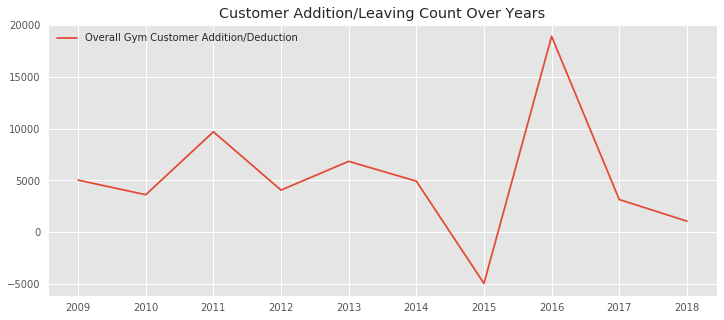

In [11]:
with plt.style.context(('seaborn', 'ggplot')):
    customer_churn_data_per_year.plot(y='Overall Gym Customer Addition/Deduction', 
                                      xticks=range(2009,2019), 
                                      title='Customer Addition/Leaving Count Over Years', 
                                      figsize=(12,5))

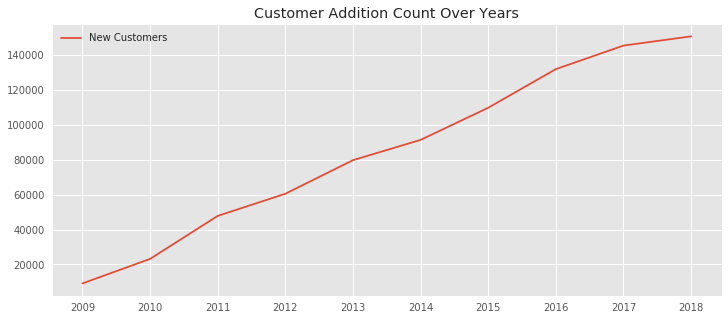

In [12]:
with plt.style.context(('seaborn', 'ggplot')):
    customer_churn_data_per_year.plot(y='New Customers', 
                                      xticks=range(2009,2019), 
                                      title='Customer Addition Count Over Years', 
                                      figsize=(12,5))

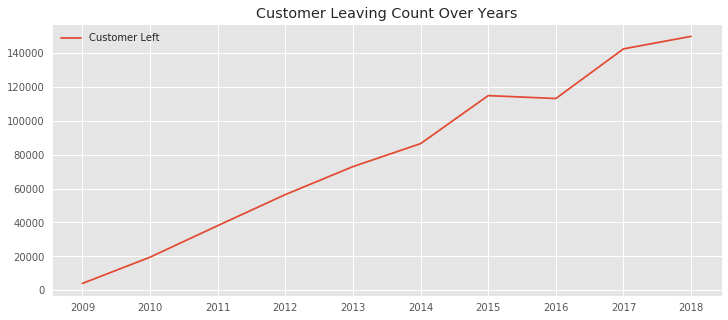

In [13]:
with plt.style.context(('seaborn', 'ggplot')):
    customer_churn_data_per_year.plot(y='Customer Left', 
                                      xticks=range(2009,2019), 
                                      title='Customer Leaving Count Over Years', 
                                      figsize=(12,5))

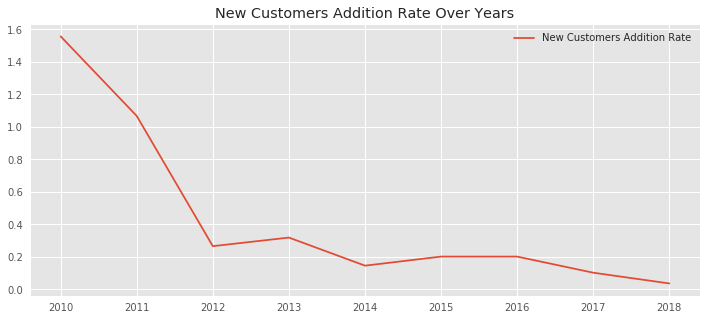

In [14]:
with plt.style.context(('seaborn', 'ggplot')):
    customer_churn_data_per_year.plot(y='New Customers Addition Rate', 
                                      xticks=range(2010,2019), 
                                      title='New Customers Addition Rate Over Years', 
                                      figsize=(12,5))

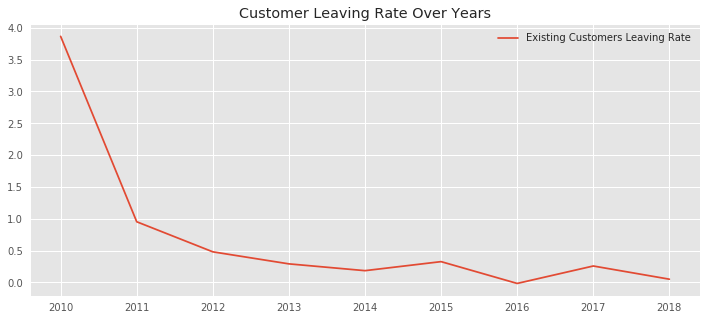

In [15]:
with plt.style.context(('seaborn', 'ggplot')):
    customer_churn_data_per_year.plot(y='Existing Customers Leaving Rate', 
                                      xticks=range(2010,2019), 
                                      title='Customer Leaving Rate Over Years', 
                                      figsize=(12,5))

### Calculating Per Month Customer Addition and Leaving to Gym

In [16]:
customer_churn_data_per_month = {}
customer_churn_data_per_month['New Customers'] = []
customer_churn_data_per_month['Customer Left'] = []

for i in range(2009, 2019):
    for j in range(1,13):
        customer_churn_data_per_month['New Customers'].append(len([1 for jd in subscriptions['Join Date'] if jd.year == i and jd.month == j]))
 
for i in range(2009, 2019):
    for j in range(1,13):
        customer_churn_data_per_month['Customer Left'].append(len([1 for ed in subscriptions['End Date'] if ed.year == i and ed.month == j]))

customer_churn_data_per_month = pd.DataFrame(customer_churn_data_per_month)
customer_churn_data_per_month.index = [datetime.date(year, month, 1) for year in range(2009,2019) for month in range(1,13)]
customer_churn_data_per_month['Overall Gym Customer Addition/Deduction'] = customer_churn_data_per_month['New Customers'] - customer_churn_data_per_month['Customer Left']
customer_churn_data_per_month['New Customers Addition Rate'] = customer_churn_data_per_month['New Customers'].pct_change()
customer_churn_data_per_month['Existing Customers Leaving Rate'] = customer_churn_data_per_month['Customer Left'].pct_change()
customer_churn_data_per_month.to_csv('customer_churn_data_per_month.csv')
customer_churn_data_per_month.head(20)

,New Customers,Customer Left,Overall Gym Customer Addition/Deduction,New Customers Addition Rate,Existing Customers Leaving Rate
2009-01-01,0,0,0,NaN,NaN
2009-02-01,0,0,0,NaN,NaN
2009-03-01,0,0,0,NaN,NaN
2009-04-01,0,0,0,NaN,NaN
2009-05-01,699,48,651,inf,inf
2009-06-01,552,56,496,-0.210300,0.166667
2009-07-01,1187,275,912,1.150362,3.910714
2009-08-01,1023,355,668,-0.138163,0.290909
2009-09-01,987,642,345,-0.035191,0.808451
2009-10-01,1546,739,807,0.566363,0.151090


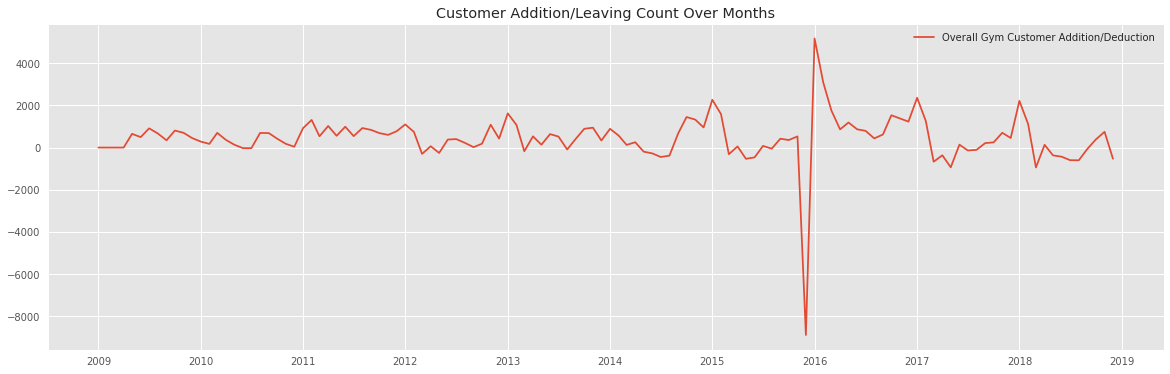

In [17]:
with plt.style.context(('seaborn', 'ggplot')):
    customer_churn_data_per_month.plot(y='Overall Gym Customer Addition/Deduction', 
                                      title='Customer Addition/Leaving Count Over Months', 
                                      figsize=(20,6))

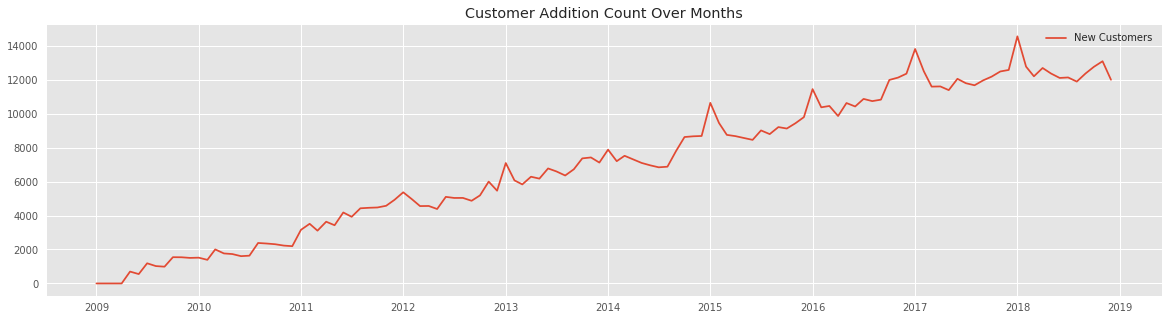

In [18]:
with plt.style.context(('seaborn', 'ggplot')):
    customer_churn_data_per_month.plot(y='New Customers', 
                                      title='Customer Addition Count Over Months', 
                                      figsize=(20,5))

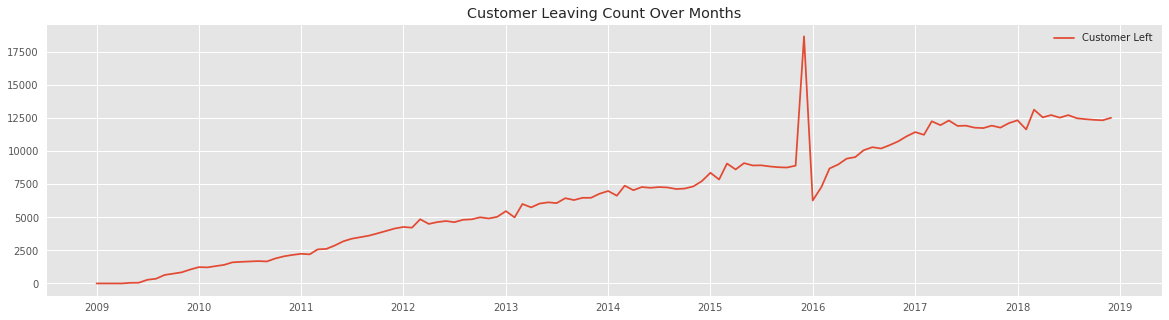

In [19]:
with plt.style.context(('seaborn', 'ggplot')):
    customer_churn_data_per_month.plot(y='Customer Left', 
                                      title='Customer Leaving Count Over Months', 
                                      figsize=(20,5))

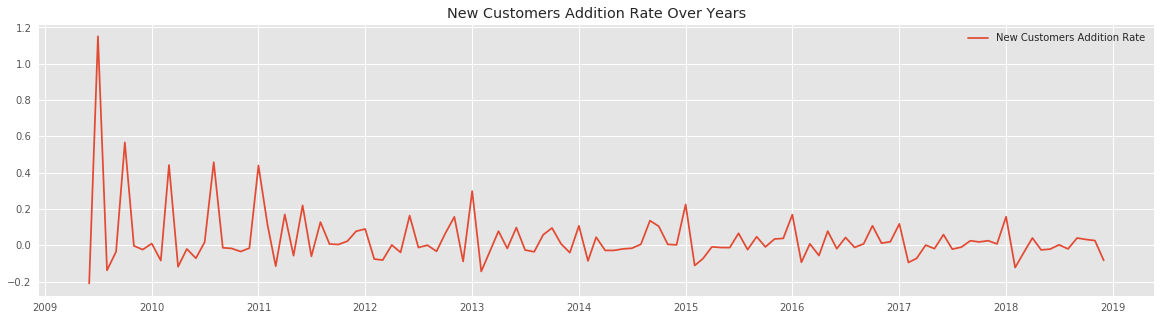

In [20]:
with plt.style.context(('seaborn', 'ggplot')):
    customer_churn_data_per_month.plot(y='New Customers Addition Rate', 
                                      title='New Customers Addition Rate Over Years', 
                                      figsize=(20,5))

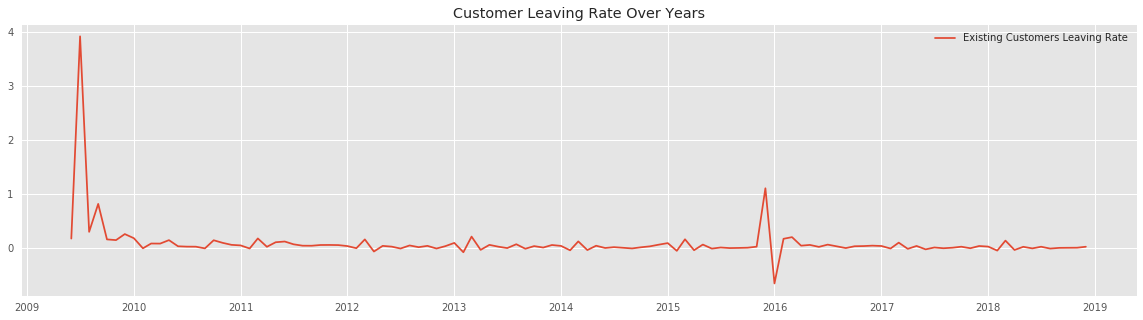

In [21]:
with plt.style.context(('seaborn', 'ggplot')):
    customer_churn_data_per_month.plot(y='Existing Customers Leaving Rate', 
                                      title='Customer Leaving Rate Over Years', 
                                      figsize=(20,5))

### Loading Visitation Data
Below we are loading both visitation data.

In [22]:
%%time

visitation_data_part1 = pd.read_csv('../input/visitationdataPART1.csv', parse_dates=['visitdate'])
visitation_data_part2 = pd.read_csv('../input/visitationdataPART2.csv', parse_dates=['visitdate'])

CPU times: user 59.1 s, sys: 6.49 s, total: 1min 5s
Wall time: 1min 5s


#### Gym Visit Time method
Below method takes users visiting time as input and returns when user visits gym.

In [23]:
def gym_visit_time(tm):
    if tm >= datetime.time(4,0) and tm <= datetime.time(11,59):
        return 'Morning'
    elif tm >= datetime.time(12,1) and tm <= datetime.time(17,0):
        return 'AfterNoon'
    elif tm >= datetime.time(17,1) and tm <= datetime.time(20,0):
        return 'Evening'
    elif tm >= datetime.time(20,1) and tm <= datetime.time(23,59):
        return 'Night'
    else:
        return 'LateNight'

### Visitation Data Cleaning and Attribute Creation
Below we are first combining visitation data from 2 csv files. We are then converting `TimeofVisit` attribute to `datetime.time` format.

Using `TimeofVisit` attribute we find out when particular person visits Gym.

In [24]:
%%time

visitation_data = pd.concat((visitation_data_part1,visitation_data_part2))
visitation_data = visitation_data.set_index('CustomerID')
visitation_data['TimeofVisit'] = [datetime.time(int(dt.split(':')[0]),int(dt.split(':')[1])) for dt in visitation_data['TimeofVisit']]
visitation_data['VisitGroup'] = [gym_visit_time(tm) for tm in visitation_data['TimeofVisit']]
visitation_data = pd.get_dummies(visitation_data, columns=['VisitGroup'])
print('Visitation Dataset Size : ',visitation_data.shape)
del visitation_data_part1, visitation_data_part2

Visitation Dataset Size :  (69514576, 8)
CPU times: user 3min 22s, sys: 18.5 s, total: 3min 40s
Wall time: 3min 37s


In [25]:
#print('Visitation Dataset Size : ',visitation_data.shape)
visitation_data.head(10)

,visitdate,TimeofVisit,peakvisits,VisitGroup_AfterNoon,VisitGroup_Evening,VisitGroup_LateNight,VisitGroup_Morning,VisitGroup_Night
CustomerID,,,,,,,,
126444,2009-05-01,05:45:00,False,0,0,0,1,0
456610,2009-05-01,05:45:00,False,0,0,0,1,0
293763,2009-05-01,06:00:00,False,0,0,0,1,0
151253,2009-05-01,06:15:00,False,0,0,0,1,0
476569,2009-05-01,06:15:00,False,0,0,0,1,0
360862,2009-05-01,06:15:00,False,0,0,0,1,0
562,2009-05-01,06:45:00,False,0,0,0,1,0
528681,2009-05-01,06:45:00,False,0,0,0,1,0
639387,2009-05-01,06:45:00,False,0,0,0,1,0


In [26]:
visitation_data.dtypes

visitdate               datetime64[ns]
TimeofVisit                     object
peakvisits                        bool
VisitGroup_AfterNoon             uint8
VisitGroup_Evening               uint8
VisitGroup_LateNight             uint8
VisitGroup_Morning               uint8
VisitGroup_Night                 uint8
dtype: object

### User Visitation Time to Gym Visualisation

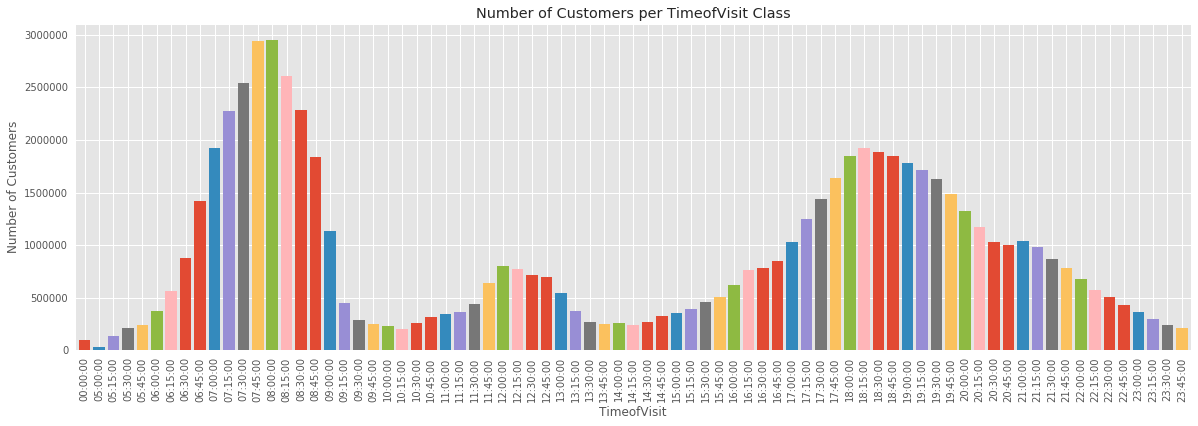

In [27]:
with plt.style.context(('seaborn', 'ggplot')):
    visitation_data.groupby('TimeofVisit').count()['peakvisits'].plot(kind='bar',figsize=(20,6), width=0.80, title='Number of Customers per TimeofVisit Class');
    plt.ylabel('Number of Customers');

### Creating Visit Time Groups Dataframe
Below we are creating new dataframe from visitation data. It finds out how many times user visited Gym during particular VisitGroup(like Monring,Evening etc). Based on that it decides each users visiting group based on maximum number of entry for particular group. If user has visited gym mostly in Morning then he's morning person.

In [28]:
%%time

grp_map = dict(zip(range(0,5), ['AfterNoon','Evening','LateNight','Morning','Night']))
visit_group_data = visitation_data.groupby(by='CustomerID').sum()[['VisitGroup_AfterNoon','VisitGroup_Evening','VisitGroup_LateNight','VisitGroup_Morning','VisitGroup_Night']]
visit_group_data['VisitGroup'] = [grp_map[grp] for grp in visit_group_data.values.argmax(axis=1)]
visit_group_data.head()

CPU times: user 19.5 s, sys: 5.67 s, total: 25.1 s
Wall time: 24.8 s


,VisitGroup_AfterNoon,VisitGroup_Evening,VisitGroup_LateNight,VisitGroup_Morning,VisitGroup_Night,VisitGroup
CustomerID,,,,,,
1,5.0,6.0,0.0,5.0,4.0,Evening
2,9.0,24.0,1.0,29.0,11.0,Morning
3,21.0,66.0,1.0,63.0,14.0,Evening
4,8.0,15.0,3.0,20.0,6.0,Morning
5,11.0,39.0,3.0,31.0,9.0,Evening


In [29]:
visitation_data.head(20)

,visitdate,TimeofVisit,peakvisits,VisitGroup_AfterNoon,VisitGroup_Evening,VisitGroup_LateNight,VisitGroup_Morning,VisitGroup_Night
CustomerID,,,,,,,,
126444,2009-05-01,05:45:00,False,0,0,0,1,0
456610,2009-05-01,05:45:00,False,0,0,0,1,0
293763,2009-05-01,06:00:00,False,0,0,0,1,0
151253,2009-05-01,06:15:00,False,0,0,0,1,0
476569,2009-05-01,06:15:00,False,0,0,0,1,0
360862,2009-05-01,06:15:00,False,0,0,0,1,0
562,2009-05-01,06:45:00,False,0,0,0,1,0
528681,2009-05-01,06:45:00,False,0,0,0,1,0
639387,2009-05-01,06:45:00,False,0,0,0,1,0


### Merging Subscriptions Dataset with Visitation Data
Below we are first merging subscriptions data with `TimeofVisit` data of visitation dataset. We are then adding `peakvisits` and `VisitGroup` attributes from visitation dataset. We also find out `VisitRate` for each user based on number of days he visited gym divided by number of days he/she has membership. We then decide user `VisitFrequency` based on `VisitRate`. We also has introduced column named `PeakVisitRate` which is percent of visits made by users during Peak Time. Another column created from `PeakVisitRate` is `PeakVisitRateGroup` which divides users into 3 groups (Those whose visits are during peak time more than 80% time,those who are between 50-80% and those whose less than 50%).

In [30]:
%%time

subscriptions = subscriptions.join(visitation_data.groupby(by='CustomerID').count()['TimeofVisit'])
subscriptions = subscriptions.join(visitation_data.groupby(by='CustomerID').sum()['peakvisits'])
subscriptions = subscriptions.join(visit_group_data['VisitGroup'])
subscriptions = subscriptions.rename(columns = {'TimeofVisit': 'NoOfVisits'})
subscriptions['VisitRate'] = subscriptions['NoOfVisits'] / (subscriptions['Membership Days']+1)
subscriptions['VisitRate'] = [(0.0 if rate >1.0 and rate < 0.0 else rate) for rate in subscriptions['VisitRate']]
subscriptions['VisitFrequency'] = [('VeryRegular' if rate > 0.80 else 'Regular' if rate > 0.5 and rate <=0.80 else 'Irregular') for rate in subscriptions['VisitRate']]
subscriptions['PeakVisitRate'] = subscriptions['peakvisits'] / (subscriptions['NoOfVisits']+1)
subscriptions['PeakVisitRate'] = [(0.0 if rate >1.0 and rate < 0.0 else rate) for rate in subscriptions['PeakVisitRate']]
subscriptions['PeakVisitRateGroup'] = [('MostlyVisitDuringPeak' if rate > 0.80 else '50To80PercentPeak' if rate >0.50 and rate <= 0.80 else 'LessThan50PercentPeak') for rate in subscriptions['PeakVisitRate']]

subscriptions.head()

CPU times: user 37.6 s, sys: 8.76 s, total: 46.4 s
Wall time: 45.2 s


,Club,Join Date,Affluence,Gender,Subscription Type,End Date,BirthYear,Left_Gym,Age,QuitAge,...,QuitAgeGroup,Membership Days,MembershipDuration,NoOfVisits,peakvisits,VisitGroup,VisitRate,VisitFrequency,PeakVisitRate,PeakVisitRateGroup
CustomerID,,,,,,,,,,,,,,,,,,,,,
1,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1992,1,19,19,...,QuitAge_Group_12_20,0,LessThan6Months,20.0,9.0,Evening,20.000000,VeryRegular,0.428571,LessThan50PercentPeak
2,Greenwich,2018-06-01,A,Female,Standard,2019-08-01,1972,0,46,47,...,QuitAge_Group_41_50,426,Between1To2Years,74.0,41.0,Morning,0.173302,Irregular,0.546667,50To80PercentPeak
3,Islington,2018-03-01,B,Female,Standard,2018-10-01,1985,1,33,33,...,QuitAge_Group_31_40,214,Between6MonthsTo1Year,165.0,110.0,Evening,0.767442,Regular,0.662651,50To80PercentPeak
4,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,1972,1,43,43,...,QuitAge_Group_41_50,61,LessThan6Months,52.0,32.0,Morning,0.838710,VeryRegular,0.603774,50To80PercentPeak
5,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,1982,1,33,33,...,QuitAge_Group_31_40,214,Between6MonthsTo1Year,93.0,63.0,Evening,0.432558,Irregular,0.670213,50To80PercentPeak


### Backfilling Missing Data

In [31]:
subscriptions = subscriptions.fillna(method='backfill')

### Saving Final Cleaned Dataset.

In [32]:
subscriptions.to_csv('Final_Subscriptions.csv')

### Visualise Membership Days Histogram

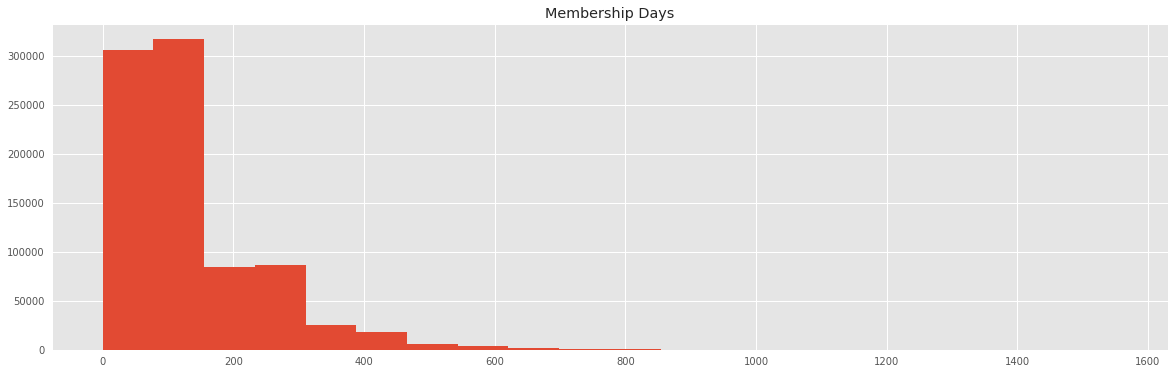

In [33]:
with plt.style.context(('seaborn', 'ggplot')):
    subscriptions.hist(column = 'Membership Days', bins=20, figsize=(20,6))

### Visualise Number Of Visited Days Histogram

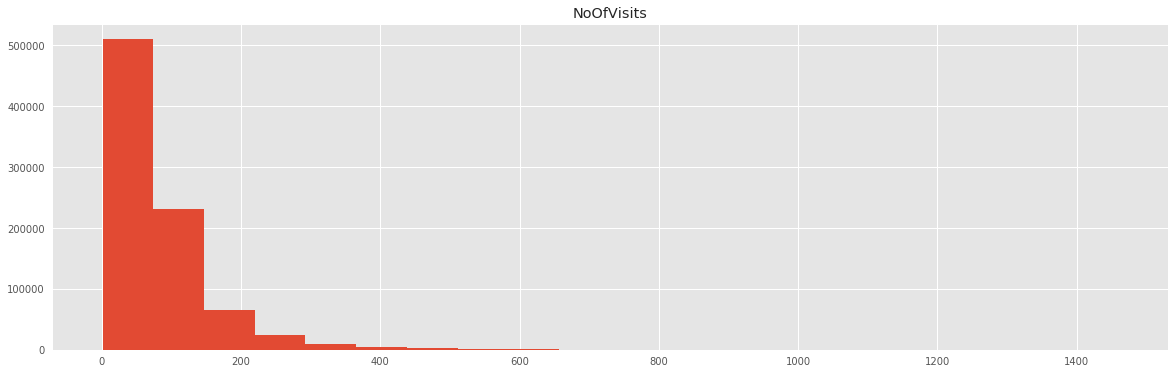

In [34]:
with plt.style.context(('seaborn', 'ggplot')):
    subscriptions.hist(column = 'NoOfVisits', bins=20, figsize=(20,6))

### Visualise PeakVisits Histogram

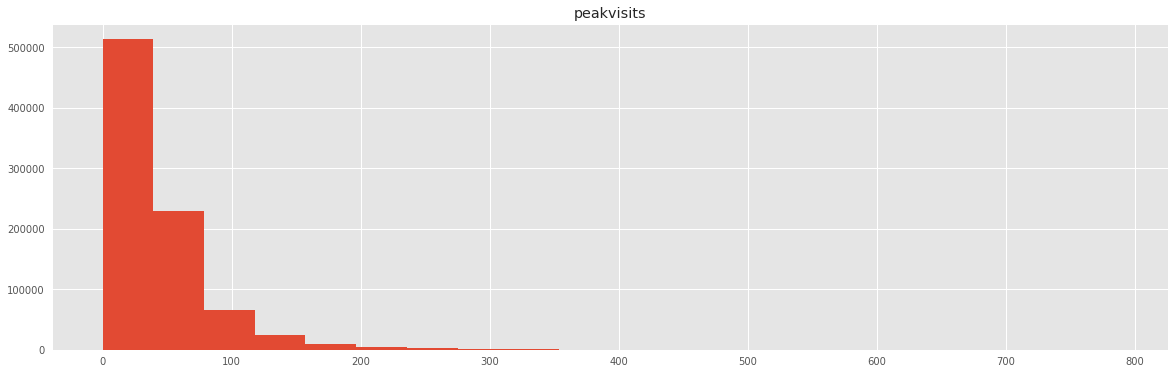

In [35]:
with plt.style.context(('seaborn', 'ggplot')):
    subscriptions.hist(column = 'peakvisits', bins=20, figsize=(20,6))

### Visualising VisitFrequency

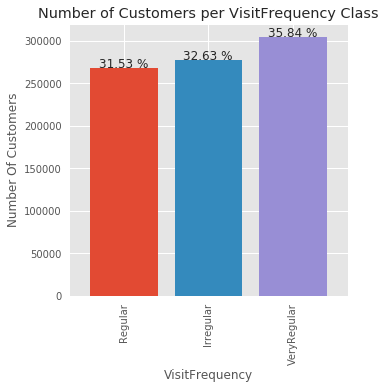

In [36]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions.VisitFrequency)
    subscriptions.groupby('VisitFrequency').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(5,5), width=0.80,title='Number of Customers per VisitFrequency Class')
    plt.ylabel('Number Of Customers')
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.3,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=12)

Current Customer Distribution:  Counter({'Irregular': 50031, 'Regular': 2311, 'VeryRegular': 35})
Past Customer Distribution:  Counter({'VeryRegular': 304596, 'Regular': 265693, 'Irregular': 227367})


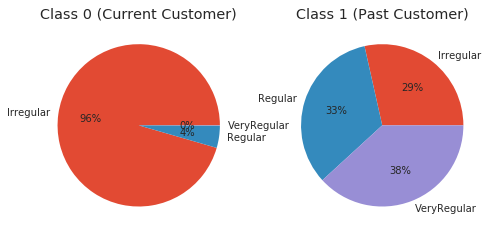

In [37]:
with plt.style.context(('seaborn', 'ggplot')):    
    freq_1 = Counter(subscriptions[subscriptions['Left_Gym'] == 1].VisitFrequency)
    freq_0 = Counter(subscriptions[subscriptions['Left_Gym'] == 0].VisitFrequency)
    print('Current Customer Distribution: ',freq_0)
    print('Past Customer Distribution: ',freq_1)
    freq_1, freq_0 = sorted(freq_1.items(), key = lambda x: x[0]),sorted(freq_0.items(), key = lambda x: x[0])
    names1, values_1 = zip(*freq_1)
    names0, values_0 = zip(*freq_0)
    plt.subplot(121)
    plt.pie(values_0, labels=names0, autopct='%.0f%%')
    plt.title('Class 0 (Current Customer)')
    plt.subplot(122)
    plt.pie(values_1, labels=names1, autopct='%.0f%%')
    plt.title('Class 1 (Past Customer)')

### Visualise PeakVisitRateGroup

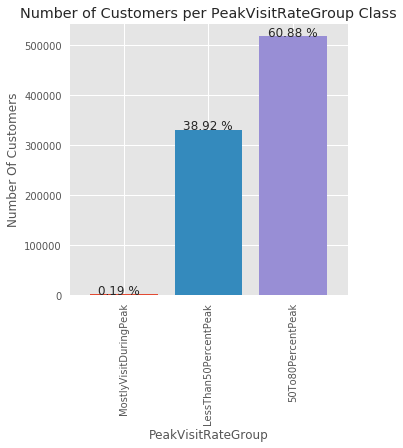

In [38]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions.PeakVisitRateGroup)
    subscriptions.groupby('PeakVisitRateGroup').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(5,5), width=0.80, title='Number of Customers per PeakVisitRateGroup Class')
    plt.ylabel('Number Of Customers')
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.3,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=12)

Current Customer Distribution:  Counter({'50To80PercentPeak': 30854, 'LessThan50PercentPeak': 21436, 'MostlyVisitDuringPeak': 87})
Past Customer Distribution:  Counter({'50To80PercentPeak': 486663, 'LessThan50PercentPeak': 309423, 'MostlyVisitDuringPeak': 1570})


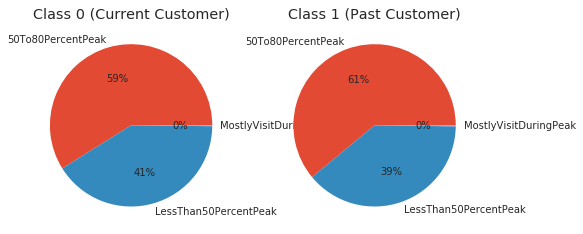

In [39]:
with plt.style.context(('seaborn', 'ggplot')):    
    freq_1 = Counter(subscriptions[subscriptions['Left_Gym'] == 1].PeakVisitRateGroup)
    freq_0 = Counter(subscriptions[subscriptions['Left_Gym'] == 0].PeakVisitRateGroup)
    print('Current Customer Distribution: ',freq_0)
    print('Past Customer Distribution: ',freq_1)
    freq_1, freq_0 = sorted(freq_1.items(), key = lambda x: x[0]),sorted(freq_0.items(), key = lambda x: x[0])
    names1, values_1 = zip(*freq_1)
    names0, values_0 = zip(*freq_0)
    plt.subplot(121)
    plt.pie(values_0, labels=names0, autopct='%.0f%%')
    plt.title('Class 0 (Current Customer)')
    plt.subplot(122)
    plt.pie(values_1, labels=names1, autopct='%.0f%%')
    plt.title('Class 1 (Past Customer)')

### Visualising VisitGroup

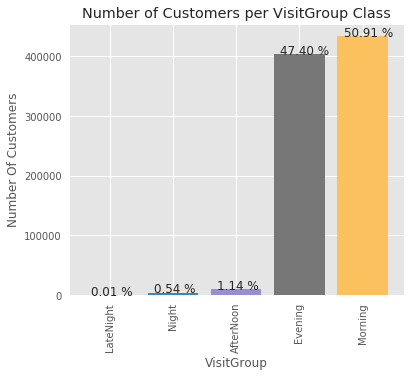

In [40]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions.VisitGroup)
    subscriptions.groupby('VisitGroup').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(6,5), width=0.80,title='Number of Customers per VisitGroup Class')
    plt.ylabel('Number Of Customers')
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.3,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=12)

Current Customer Distribution:  Counter({'Morning': 27842, 'Evening': 23876, 'AfterNoon': 401, 'Night': 255, 'LateNight': 3})
Past Customer Distribution:  Counter({'Morning': 404881, 'Evening': 379082, 'AfterNoon': 9295, 'Night': 4304, 'LateNight': 94})


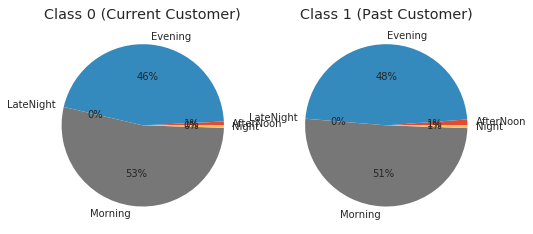

In [41]:
with plt.style.context(('seaborn', 'ggplot')):    
    freq_1 = Counter(subscriptions[subscriptions['Left_Gym'] == 1].VisitGroup)
    freq_0 = Counter(subscriptions[subscriptions['Left_Gym'] == 0].VisitGroup)
    print('Current Customer Distribution: ',freq_0)
    print('Past Customer Distribution: ',freq_1)
    freq_1, freq_0 = sorted(freq_1.items(), key = lambda x: x[0]),sorted(freq_0.items(), key = lambda x: x[0])
    names1, values_1 = zip(*freq_1)
    names0, values_0 = zip(*freq_0)
    plt.subplot(121)
    plt.pie(values_0, labels=names0, autopct='%.0f%%')
    plt.title('Class 0 (Current Customer)')
    plt.subplot(122)
    plt.pie(values_1, labels=names1, autopct='%.0f%%')
    plt.title('Class 1 (Past Customer)')

### Visualising MembershipDuration

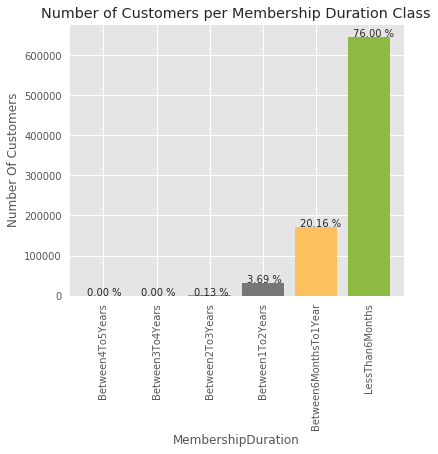

In [42]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions.MembershipDuration)
    subscriptions.groupby('MembershipDuration').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(6,5), width=0.80, title='Number of Customers per Membership Duration Class')
    plt.ylabel('Number Of Customers')
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.3,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=10)

Current Customer Distribution:  Counter({'Between6MonthsTo1Year': 40733, 'Between1To2Years': 11195, 'Between2To3Years': 437, 'Between3To4Years': 10, 'Between4To5Years': 2})
Past Customer Distribution:  Counter({'LessThan6Months': 646066, 'Between6MonthsTo1Year': 130653, 'Between1To2Years': 20196, 'Between2To3Years': 708, 'Between3To4Years': 32, 'Between4To5Years': 1})


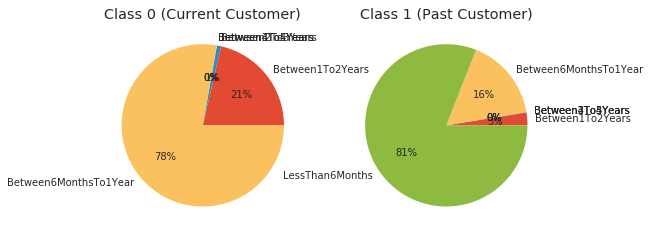

In [43]:
with plt.style.context(('seaborn', 'ggplot')):    
    freq_1 = Counter(subscriptions[subscriptions['Left_Gym'] == 1].MembershipDuration)
    freq_0 = Counter(subscriptions[subscriptions['Left_Gym'] == 0].MembershipDuration)
    print('Current Customer Distribution: ',freq_0)
    print('Past Customer Distribution: ',freq_1)
    freq_1, freq_0 = sorted(freq_1.items(), key = lambda x: x[0]),sorted(freq_0.items(), key = lambda x: x[0])
    names1, values_1 = zip(*freq_1)
    names0, values_0 = zip(*freq_0)
    plt.subplot(121)
    plt.pie(values_0, labels=names0, autopct='%.0f%%')
    plt.title('Class 0 (Current Customer)')
    plt.subplot(122)
    plt.pie(values_1, labels=names1, autopct='%.0f%%')
    plt.title('Class 1 (Past Customer)')

### Visualising Joining AgeGroup

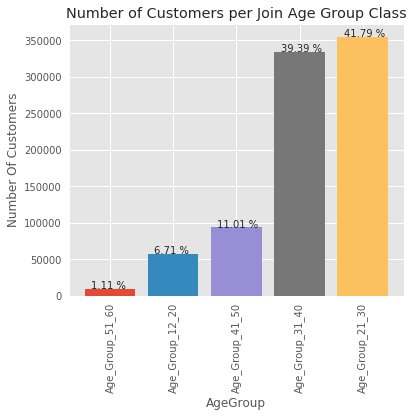

In [44]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions.AgeGroup)
    subscriptions.groupby('AgeGroup').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(6,5), width=0.80, title='Number of Customers per Join Age Group Class');
    plt.ylabel('Number Of Customers')
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.3,freq[key]+5, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=10)

Current Customer Distribution:  Counter({'Age_Group_31_40': 21790, 'Age_Group_21_30': 20331, 'Age_Group_41_50': 6336, 'Age_Group_12_20': 3283, 'Age_Group_51_60': 637})
Past Customer Distribution:  Counter({'Age_Group_21_30': 334883, 'Age_Group_31_40': 312997, 'Age_Group_41_50': 87286, 'Age_Group_12_20': 53719, 'Age_Group_51_60': 8771})


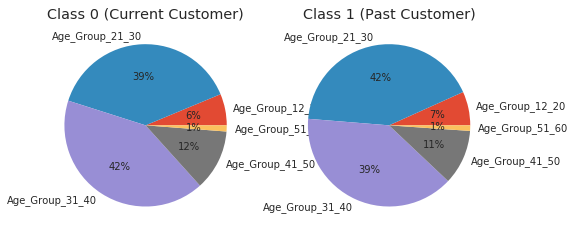

In [45]:
with plt.style.context(('seaborn', 'ggplot')):    
    freq_1 = Counter(subscriptions[subscriptions['Left_Gym'] == 1].AgeGroup)
    freq_0 = Counter(subscriptions[subscriptions['Left_Gym'] == 0].AgeGroup)
    print('Current Customer Distribution: ',freq_0)
    print('Past Customer Distribution: ',freq_1)
    freq_1, freq_0 = sorted(freq_1.items(), key = lambda x: x[0]),sorted(freq_0.items(), key = lambda x: x[0])
    names1, values_1 = zip(*freq_1)
    names0, values_0 = zip(*freq_0)
    plt.subplot(121)
    plt.pie(values_0, labels=names0, autopct='%.0f%%')
    plt.title('Class 0 (Current Customer)')
    plt.subplot(122)
    plt.pie(values_1, labels=names1, autopct='%.0f%%')
    plt.title('Class 1 (Past Customer)')

### Visualising Quit AgeGroup

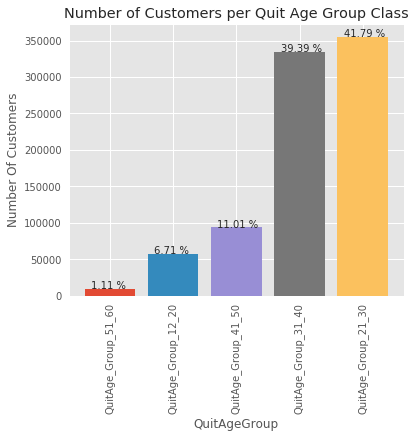

In [46]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions.QuitAgeGroup)
    subscriptions.groupby('QuitAgeGroup').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(6,5), width=0.80, title='Number of Customers per Quit Age Group Class');
    plt.ylabel('Number Of Customers')
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.3,freq[key]+5, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=10)

Current Customer Distribution:  Counter({'QuitAge_Group_31_40': 21790, 'QuitAge_Group_21_30': 20331, 'QuitAge_Group_41_50': 6336, 'QuitAge_Group_12_20': 3283, 'QuitAge_Group_51_60': 637})
Past Customer Distribution:  Counter({'QuitAge_Group_21_30': 334883, 'QuitAge_Group_31_40': 312997, 'QuitAge_Group_41_50': 87286, 'QuitAge_Group_12_20': 53719, 'QuitAge_Group_51_60': 8771})


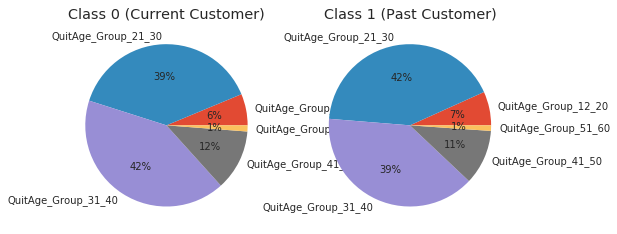

In [47]:
with plt.style.context(('seaborn', 'ggplot')):    
    freq_1 = Counter(subscriptions[subscriptions['Left_Gym'] == 1].QuitAgeGroup)
    freq_0 = Counter(subscriptions[subscriptions['Left_Gym'] == 0].QuitAgeGroup)
    print('Current Customer Distribution: ',freq_0)
    print('Past Customer Distribution: ',freq_1)
    freq_1, freq_0 = sorted(freq_1.items(), key = lambda x: x[0]),sorted(freq_0.items(), key = lambda x: x[0])
    names1, values_1 = zip(*freq_1)
    names0, values_0 = zip(*freq_0)
    plt.subplot(121)
    plt.pie(values_0, labels=names0, autopct='%.0f%%')
    plt.title('Class 0 (Current Customer)')
    plt.subplot(122)
    plt.pie(values_1, labels=names1, autopct='%.0f%%')
    plt.title('Class 1 (Past Customer)')

### Visualising Gender Distribution

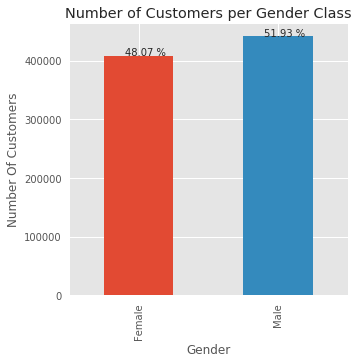

In [48]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions.Gender)
    subscriptions.groupby('Gender').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(5,5), title='Number of Customers per Gender Class');
    plt.ylabel('Number Of Customers')
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.1,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=10)

Current Customer Distribution:  Counter({'Male': 27880, 'Female': 24497})
Past Customer Distribution:  Counter({'Male': 413553, 'Female': 384103})


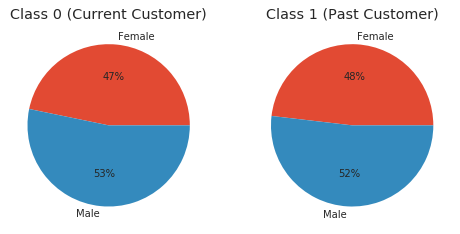

In [49]:
with plt.style.context(('seaborn', 'ggplot')):    
    freq_1 = Counter(subscriptions[subscriptions['Left_Gym'] == 1].Gender)
    freq_0 = Counter(subscriptions[subscriptions['Left_Gym'] == 0].Gender)
    print('Current Customer Distribution: ',freq_0)
    print('Past Customer Distribution: ',freq_1)
    freq_1, freq_0 = sorted(freq_1.items(), key = lambda x: x[0]),sorted(freq_0.items(), key = lambda x: x[0])
    names1, values_1 = zip(*freq_1)
    names0, values_0 = zip(*freq_0)
    plt.subplot(121)
    plt.pie(values_0, labels=names0, autopct='%.0f%%')
    plt.title('Class 0 (Current Customer)')
    plt.subplot(122)
    plt.pie(values_1, labels=names1, autopct='%.0f%%')
    plt.title('Class 1 (Past Customer)')

### Visualising Subscription Type

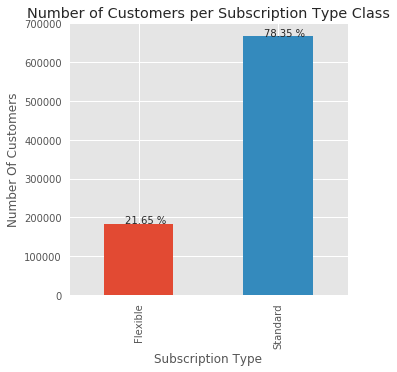

In [50]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions['Subscription Type'])
    subscriptions.groupby('Subscription Type').count()['NoOfVisits'].plot(kind='bar', figsize=(5,5), title='Number of Customers per Subscription Type Class');
    plt.ylabel('Number Of Customers')
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.1,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=10)

Current Customer Distribution:  Counter({'Standard': 46455, 'Flexible': 5922})
Past Customer Distribution:  Counter({'Standard': 619521, 'Flexible': 178135})


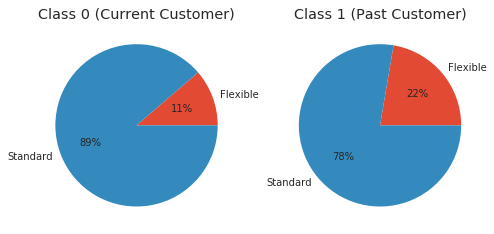

In [51]:
with plt.style.context(('seaborn', 'ggplot')):    
    freq_1 = Counter(subscriptions[subscriptions['Left_Gym'] == 1]['Subscription Type'])
    freq_0 = Counter(subscriptions[subscriptions['Left_Gym'] == 0]['Subscription Type'])
    print('Current Customer Distribution: ',freq_0)
    print('Past Customer Distribution: ',freq_1)
    freq_1, freq_0 = sorted(freq_1.items(), key = lambda x: x[0]),sorted(freq_0.items(), key = lambda x: x[0])
    names1, values_1 = zip(*freq_1)
    names0, values_0 = zip(*freq_0)
    plt.subplot(121)
    plt.pie(values_0, labels=names0, autopct='%.0f%%')
    plt.title('Class 0 (Current Customer)')
    plt.subplot(122)
    plt.pie(values_1, labels=names1, autopct='%.0f%%')
    plt.title('Class 1 (Past Customer)')

### Visualising Affluence

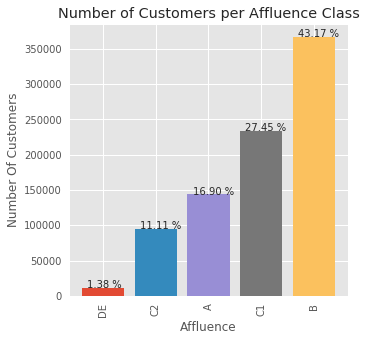

In [52]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions['Affluence'])
    subscriptions.groupby('Affluence').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(5,5), width=0.80, title='Number of Customers per Affluence Class');
    plt.ylabel('Number Of Customers')
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.3,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ ' %', fontsize=10)

Current Customer Distribution:  Counter({'B': 22119, 'C1': 14473, 'A': 9475, 'C2': 5704, 'DE': 606})
Past Customer Distribution:  Counter({'B': 344812, 'C1': 218849, 'A': 134149, 'C2': 88702, 'DE': 11144})


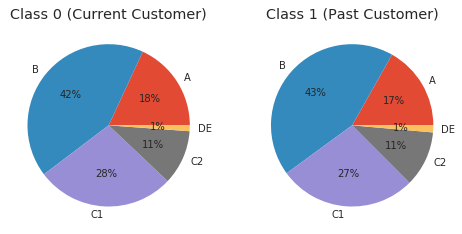

In [53]:
with plt.style.context(('seaborn', 'ggplot')):    
    freq_1 = Counter(subscriptions[subscriptions['Left_Gym'] == 1].Affluence)
    freq_0 = Counter(subscriptions[subscriptions['Left_Gym'] == 0].Affluence)
    print('Current Customer Distribution: ',freq_0)
    print('Past Customer Distribution: ',freq_1)
    freq_1, freq_0 = sorted(freq_1.items(), key = lambda x: x[0]),sorted(freq_0.items(), key = lambda x: x[0])
    names1, values_1 = zip(*freq_1)
    names0, values_0 = zip(*freq_0)
    plt.subplot(121)
    plt.pie(values_0, labels=names0, autopct='%.0f%%')
    plt.title('Class 0 (Current Customer)')
    plt.subplot(122)
    plt.pie(values_1, labels=names1, autopct='%.0f%%')
    plt.title('Class 1 (Past Customer)')

### Visualising Club

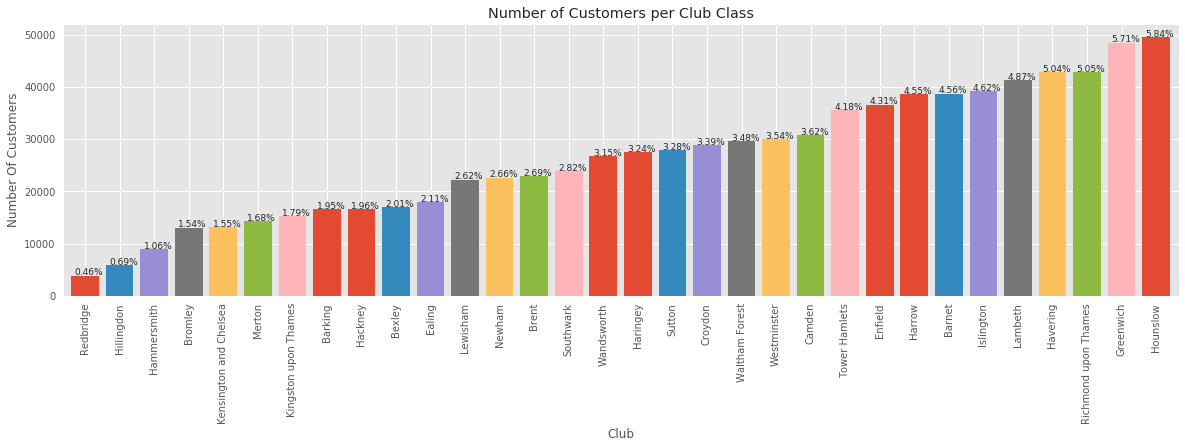

In [54]:
with plt.style.context(('seaborn', 'ggplot')):
    freq = Counter(subscriptions['Club'])
    subscriptions.groupby('Club').count()['NoOfVisits'].sort_values().plot(kind='bar', figsize=(20,5), width=0.80, title='Number of Customers per Club Class');
    plt.ylabel('Number Of Customers')
    for i, (key, val) in enumerate(sorted(freq.items(),key=lambda x: x[1])):
        plt.text(i-0.3,freq[key]+100, '%.2f'%(freq[key]*100/subscriptions.shape[0])+ '%', fontsize=9)

### Visualising User's Has Left Gym/Still Member Distribution

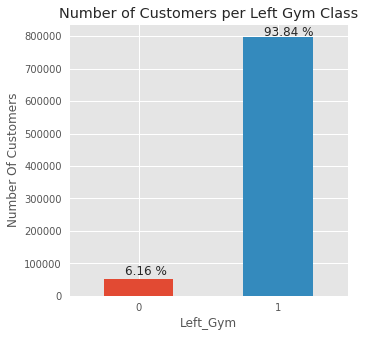

In [55]:
with plt.style.context(('seaborn', 'ggplot')):
    left_count = Counter(subscriptions.Left_Gym)
    subscriptions.groupby('Left_Gym').count()['NoOfVisits'].plot(kind='bar', figsize=(5,5), title='Number of Customers per Left Gym Class')
    plt.ylabel('Number Of Customers')
    plt.xticks(rotation='horizontal')
    plt.text(0-0.1,65000, '%.2f'%(left_count[0]*100/subscriptions.shape[0])+ ' %', fontsize=12)
    plt.text(1-0.1,800000, '%.2f'%(left_count[1]*100/subscriptions.shape[0])+ ' %',fontsize=12);

### Creating Features, Target Variables Arrays for ML Model

In [56]:
final_X_df = pd.get_dummies(subscriptions[['Club','Affluence','Gender','Subscription Type','Age','Membership Days','NoOfVisits', 'peakvisits', 'VisitGroup','AgeGroup','MembershipDuration','VisitRate','VisitFrequency','PeakVisitRate','PeakVisitRateGroup','QuitAge', 'QuitAgeGroup']],
                   columns=['Club','Affluence','Gender','Subscription Type', 'VisitGroup', 'AgeGroup','MembershipDuration','VisitFrequency','PeakVisitRateGroup', 'QuitAgeGroup'])
X, Y = final_X_df.values, subscriptions['Left_Gym'].values
print('Dataset Shapes : ',X.shape, Y.shape)

Dataset Shapes :  (850033, 75) (850033,)


### Split Data Into Train/Test Sets
Below we are splitting dataset into Train set(70%) and Test sets(30%).

In [57]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.70, test_size=0.30, stratify=Y, random_state=123)
print('Train/Test Shapes : ',X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Train/Test Shapes :  (595023, 75) (255010, 75) (595023,) (255010,)


### Scaling Data, Initializing Model And Training Model
We'll use `RobustScaler` to scale data so that it converges fast and then train it using `LogisticRegression`.

In [58]:
rs = RobustScaler()
X_train = rs.fit_transform(X_train)
X_test = rs.transform(X_test)

In [59]:
%%time

lr = LogisticRegression(solver='lbfgs', max_iter=800,)
lr.fit(X_train, Y_train)

CPU times: user 1min 48s, sys: 88 ms, total: 1min 48s
Wall time: 1min 3s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=800,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
%%time

rf_classif = RandomForestClassifier(n_estimators=200,max_features='auto',n_jobs=-1)
rf_classif.fit(X_train, Y_train)

CPU times: user 6min 34s, sys: 968 ms, total: 6min 35s
Wall time: 1min 41s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

### Evaluation Metrics
Below we are printing model accuracy on both training and test sets. We are also printing classification report which prints Precision, Recall and f1-score for each class.

In [61]:
Y_preds = lr.predict(X_test)

print('Test Accuracy : %.2f'%lr.score(X_test, Y_test))
print('Train Accuracy : %.2f'%lr.score(X_train, Y_train))
print('Test Classficiation Report : ')
print(classification_report(Y_test, Y_preds))

Test Accuracy : 0.99
Train Accuracy : 0.99
Test Classficiation Report : 
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     15713
           1       0.99      0.99      0.99    239297

    accuracy                           0.99    255010
   macro avg       0.94      0.95      0.94    255010
weighted avg       0.99      0.99      0.99    255010



In [62]:
Y_preds_rf = rf_classif.predict(X_test)

print('Test Accuracy : %.2f'%rf_classif.score(X_test, Y_test))
print('Train Accuracy : %.2f'%rf_classif.score(X_train, Y_train))
print('Test Classficiation Report : ')
print(classification_report(Y_test, Y_preds_rf))

Test Accuracy : 0.99
Train Accuracy : 1.00
Test Classficiation Report : 
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     15713
           1       1.00      0.99      1.00    239297

    accuracy                           0.99    255010
   macro avg       0.95      0.97      0.96    255010
weighted avg       0.99      0.99      0.99    255010



### Visualising Confusion Matrix

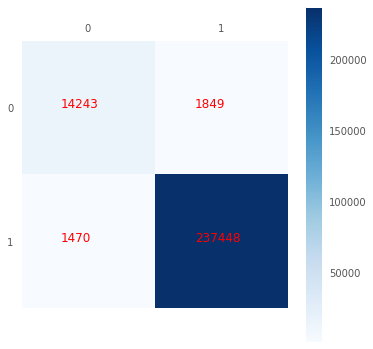

In [63]:
conf_mat = confusion_matrix(Y_test, Y_preds)

with plt.style.context(('seaborn', 'ggplot')):
    fig = plt.figure(figsize=(6,6))
    plt.matshow(conf_mat, cmap = plt.cm.Blues, fignum=1)
    plt.colorbar()
    plt.grid(None)
    for i in range(2):
        for j in range(2):
            plt.text(i-0.2,j, str(conf_mat[i,j]), fontsize=12, color='red');

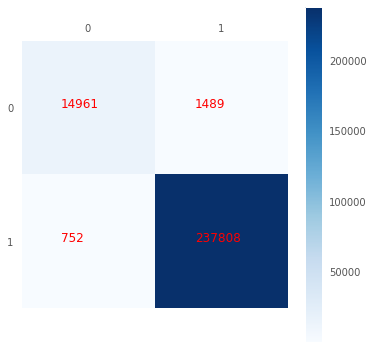

In [64]:
conf_mat = confusion_matrix(Y_test, Y_preds_rf)

with plt.style.context(('seaborn', 'ggplot')):
    fig = plt.figure(figsize=(6,6))
    plt.matshow(conf_mat, cmap = plt.cm.Blues, fignum=1)
    plt.colorbar()
    plt.grid(None)
    for i in range(2):
        for j in range(2):
            plt.text(i-0.2,j, str(conf_mat[i,j]), fontsize=12, color='red');

In [65]:
coef_df_rf = pd.DataFrame({'Features':final_X_df.columns, 'Coefficient Values': rf_classif.feature_importances_})

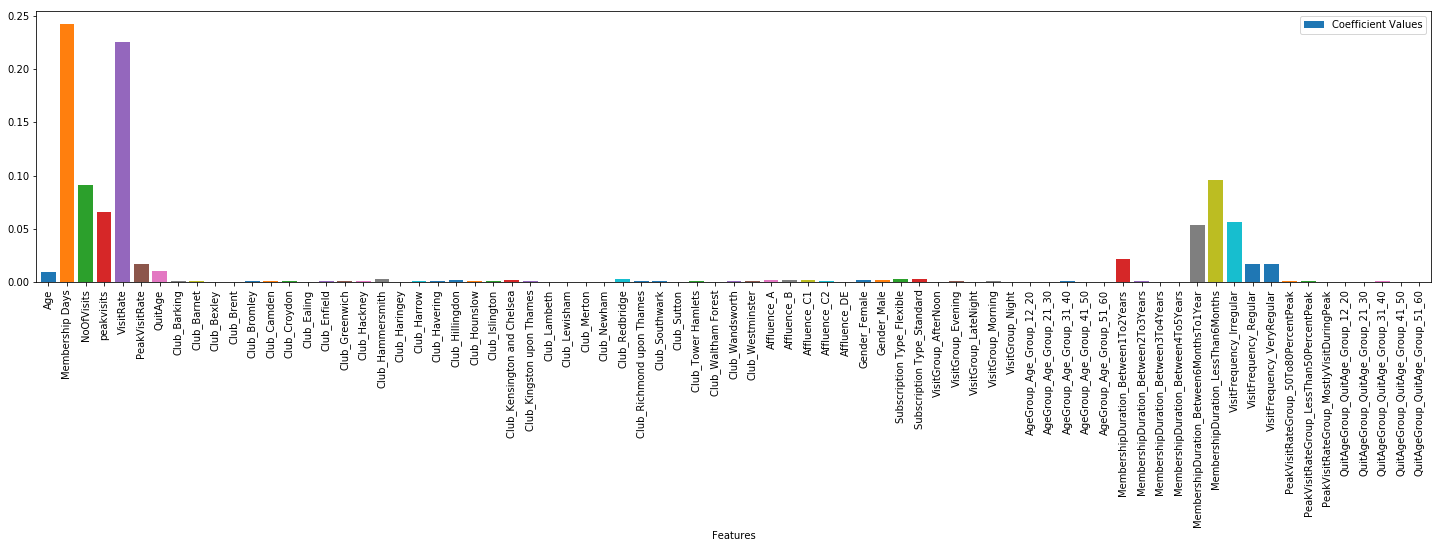

In [66]:
coef_df_rf.plot(x='Features',y='Coefficient Values', kind='bar',figsize=(25,5), width=0.8);

### Creating DataFrame Based On ML Model's Coefficients

In [67]:
coef_df = pd.DataFrame({'Features':final_X_df.columns, 'Coefficient Values': lr.coef_[0]})
coef_positives = coef_df[coef_df['Coefficient Values'] > 0.0].sort_values('Coefficient Values')
coef_negatives = coef_df[coef_df['Coefficient Values'] < 0.0].sort_values('Coefficient Values', ascending=False)

### Positive Coefficients Affecting Positive Class 1 (Person Leaving Gym - High Churn Rate)
Below we are printing list of attributes which are positive. A positive value has a positive impact on our predicted variable. A good example is “SubscriptionType_Flexible”: The positive relation to churn means that having this type of subscription also increases the probability of a customer to churn.

Below are list of attributes which contributes to customers churn:
* Cutomer beloging to `Affluence Groups A,B,C1` are more likely to churn than other groups
* People with age group `(12-20), (31-40) and (41-50),(51-60)` are very less likely to continue Gym.
* People beloging to `club [Barnet, Camden, Crodydon, Enfield, Greenwich, Hariengey, Harrow, Hovering, Hounslow, Islington, Lambeth, Richamond upon Thames, Southwark, Sutton, Tower Hamlets, Waltham Forest, Wandsworth, Westministor]` are more likely to churn than people belonging to other clubs. It might be possible as there might be options available. People from `Westministor Club` are also more likely to quit as it has high positive coefficients.
* `Male` are also more likely to churn than Female.
* People with `Membership` `less than 6 Months` or `more than 2 years` are more likely to churn. People generally quits Gym in first 6 months hence needs to be motivated to continue Gym hence those with less than 6 months are very highly to quit. People with more than 2 years also needs to be motivated or they might have found out other better option which can be `more cheap` or has `more equipments`. We can also say that people can continue Gym for atmost 2 years and then needs motivation to continue further or other perks.
* People visitng during peak hours are also more likely to quit. `PeakVisitRateGroup_MostlyVisitDuringPeak`
* people with `subscription type Flexible` are more likely to quit. May be because price is higher than Standard.
* People which are irregular, not regular and little regular are more likely to quit. These are those people who visited gym `less than 50% days` from total membership days. Only most regular people continues Gym. People who visits gym less 50% of days during which they have membership are very highly to quit. You should make them very regular.
* People coming in `morning and evening` are more likely to churn. It might be because most of crowd is present during that time and Gym is at its peak (full) hence person does not get attention from trainer or gets equipments he needs.People coming in morning are more likely to quit then those cmoming in evening. May be they are not able to motivate themselves to wake up early. Transfer them to other time or motivate them to wake up early. Morning (4:00 AM - 11:59 AM), Evening (5:00 PM - 8:00 PM)

In [68]:
coef_positives.sort_values(by='Features')

,Features,Coefficient Values
39,Affluence_A,0.171450
40,Affluence_B,0.416907
41,Affluence_C1,0.028557
0,Age,8.708269
53,AgeGroup_Age_Group_12_20,0.020351
55,AgeGroup_Age_Group_31_40,0.054684
56,AgeGroup_Age_Group_41_50,0.059725
57,AgeGroup_Age_Group_51_60,0.005827
8,Club_Barnet,0.680207
12,Club_Camden,0.588472


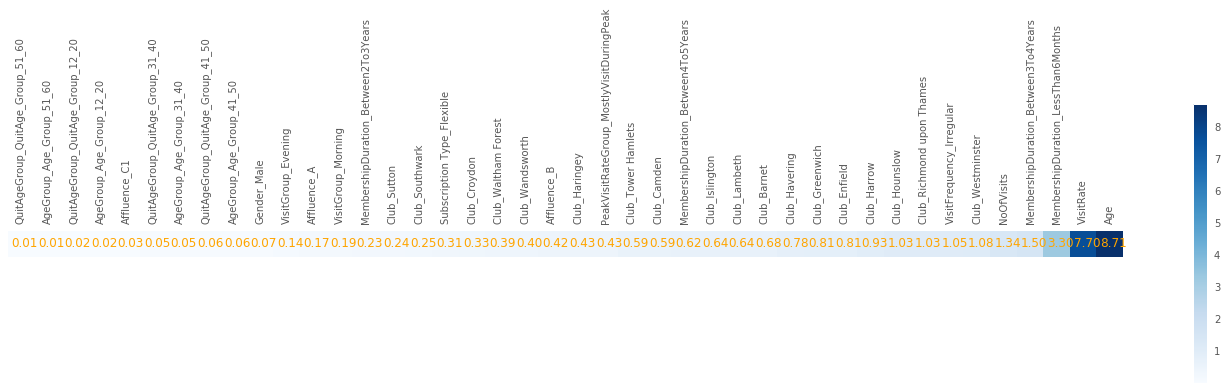

In [69]:
with plt.style.context(('seaborn', 'ggplot')):
    fig = plt.figure(figsize=(25,5))
    plt.matshow(coef_positives['Coefficient Values'].values.reshape(1,-1), fignum=1, cmap = plt.cm.Blues)
    plt.xticks(range(len(coef_positives)), coef_positives.Features, rotation='vertical')
    plt.yticks([])
    plt.grid(None)
    plt.colorbar()
    for i in range(len(coef_positives)):
        plt.text(i-0.35,0.1, '%.2f'%coef_positives['Coefficient Values'].values[i], color='orange', fontsize=12)

### Negative Coefficients Affecting Negative Class 0(Person Continuing Gym - Low Churn Rate)
Below we are printing list of attributes which has negative coefficients. A negative value has a negative impact on our predicted variable. A good example is “SubscriptionType_Standard”: The negative relation to churn means that having this type of contract also decreases the probability of a customer to churn.

Below are list of attributes which prevents customers to churn:
* People with `Affluence C2,DE` are less likely to quite Gym.
* People from age group `(21-30)` are less likely to quit Gym.
* People belonging to `Clubs [Barking, Bexley, Brent, Bromley, Ealing, Hackney, Hammersmith, Hillingdon, Kensington and Chelsea, Kingston upon Thames, Lewisham ,Merton, Newham, Redbridge, ]` are less likely to churn. It might be because this is only Gym facility available in area or it's best compared to competition. People from `Hmmersmith, Hillingdon and Redbridge`are very less likely to quit compared to other Clubs who are less likely as well.
* `Female` are very less likely to churn. 
* People whose `membership is between 6 Months to 2 years old` are less likely to churn.
* People who `visit during off-peak hours` are less likely to churn. It might be due to less crowd. `PeakVisitRateGroup_50To80PercentPeak`, `PeakVisitRateGroup_LessThan50PercentPeak`
* People with `Subscription Type Standard` are also less likely to churn.
* People who are `very regular` (visited gym for more than 80% of days during they had membership), `regular` and `irregular` are less likely to churn. The very regular and regular are self motivated may be.
* People coming in `Aternoon, Latenight and Night`are less likely to churn. Afternoon (12:01 PM - 5:00 PM) Night (8:00 PM - 11:59 PM), LateNight (12:01 AM - 400 AM)
* People who are not coming during peak hours are also less likely to quit.

In [70]:
coef_negatives.sort_values(by='Features')

,Features,Coefficient Values
42,Affluence_C2,-0.130959
43,Affluence_DE,-0.364454
54,AgeGroup_Age_Group_21_30,-0.019086
7,Club_Barking,-0.377770
9,Club_Bexley,-0.277825
10,Club_Brent,-0.358282
11,Club_Bromley,-0.835734
14,Club_Ealing,-0.087629
17,Club_Hackney,-0.471203
18,Club_Hammersmith,-1.366295


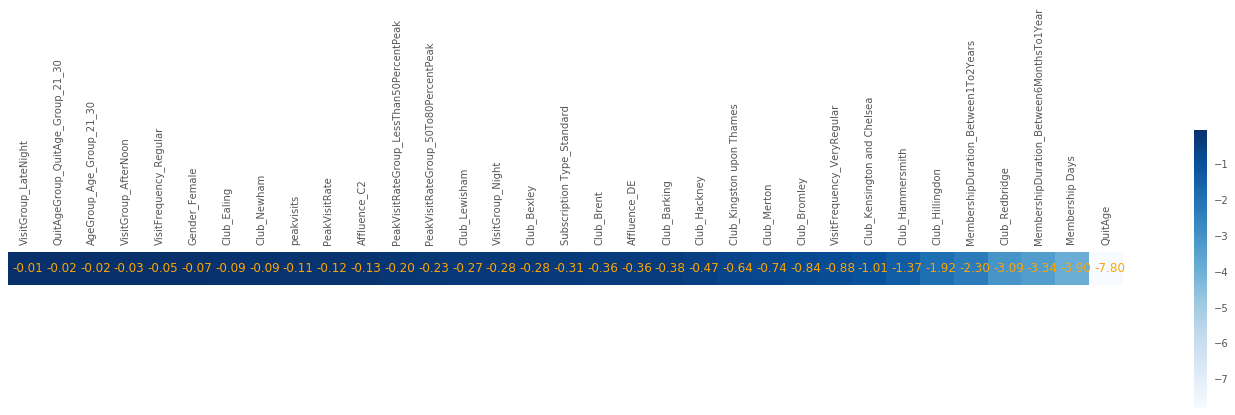

In [71]:
with plt.style.context(('seaborn', 'ggplot')):
    fig = plt.figure(figsize=(25,5))
    plt.matshow(coef_negatives['Coefficient Values'].values.reshape(1,-1), fignum=1, cmap = plt.cm.Blues)
    plt.xticks(range(len(coef_negatives)), coef_negatives.Features, rotation='vertical')
    plt.yticks([])
    plt.grid(None)
    plt.colorbar()
    for i in range(len(coef_negatives)):
        plt.text(i-0.35,0.1, '%.2f'%coef_negatives['Coefficient Values'].values[i], color='orange', fontsize=12)

### Feature Correlation with Gym Leaving Decision
Below we are printing graph with p-value of each attrbitue for association with Target Variable. Those attribute with low p-value are ones who contribute more to target prediction whereas those with hight p-value are not useful in prediction.

In [72]:
#with plt.style.context(('seaborn', 'ggplot')):
#    fig = plt.figure(figsize=(25,5))
#    corr_values = final_X_df.corrwith(subscriptions['Left_Gym']).values
#    plt.matshow(corr_values.reshape(1,-1),fignum=1, cmap = plt.cm.Blues)
#    plt.grid(None)
#    for i in range(len(final_X_df.columns)):
#        plt.text(i-0.35,0.1, '%.2f'%corr_values[i], color='orange', fontsize=8)
#    plt.xticks(range(len(final_X_df.columns)), final_X_df.columns, rotation='vertical')
#    plt.yticks([])
#    plt.colorbar();

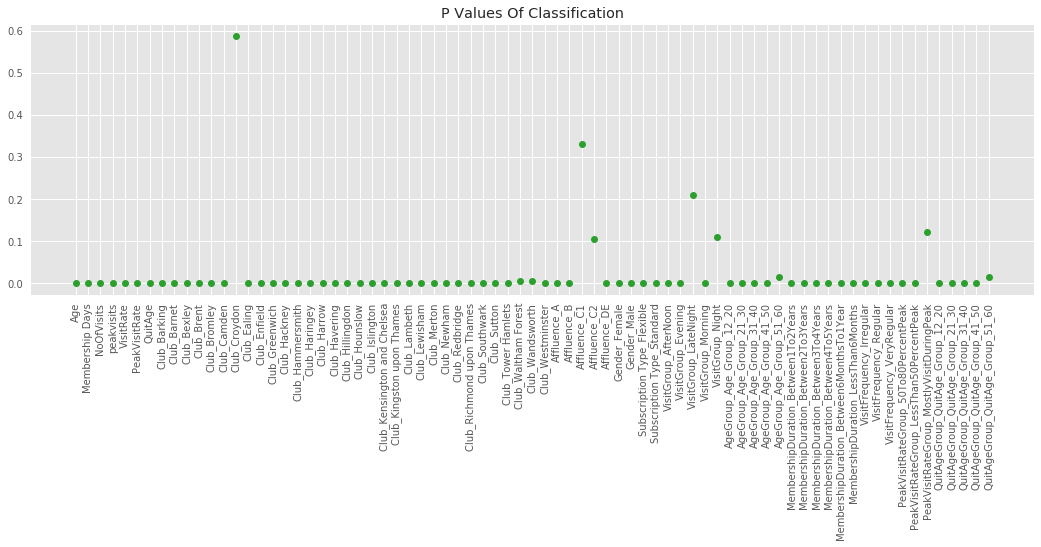

In [73]:
from sklearn.feature_selection import f_regression, f_classif, chi2

F_classif, p_value_classif = f_classif(X, Y)

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(18,5))
    #plt.subplot(121)
    plt.plot(p_value_classif, 'o', c = 'tab:green')
    plt.title('P Values Of Classification')
    plt.xticks(range(len(final_X_df.columns)), final_X_df.columns, rotation='vertical')
    #plt.subplot(122)
    #plt.plot(F_classif, 'o', c = 'tab:red')
    #plt.title('F Values Of Classification');

In [74]:
pd.read_excel('../input/Ratecard.xlsx', skiprows=1)

,Year,Flexible,Standard,Join Fee,Day Pass,Unnamed: 5,Year.1,Flexible.1,Standard.1,Join Fee.1
0,2009,25.99,20.99,5,6,NaN,2009,35.99,30.99,8
1,2010,25.99,20.99,5,6,NaN,2010,35.99,30.99,8
2,2011,25.99,20.99,5,6,NaN,2011,35.99,30.99,8
3,2012,25.99,20.99,5,6,NaN,2012,35.99,30.99,8
4,2013,25.99,20.99,5,6,NaN,2013,35.99,30.99,8
5,2014,25.99,20.99,5,6,NaN,2014,35.99,30.99,8
6,2015,25.99,20.99,5,6,NaN,2015,35.99,30.99,8
7,2016,30.99,26.99,5,6,NaN,2016,35.99,30.99,8
8,2017,30.99,26.99,5,6,NaN,2017,35.99,30.99,8
9,2018,30.99,26.99,5,6,NaN,2018,35.99,30.99,8
